In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# learning parameters
batch_size = 128
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 256 # latent vector size
k = 2 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.
C:\Users\JHellmers\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

### Training Tools

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0001)

# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [8]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [9]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [10]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

### Question 1

469it [01:09,  6.72it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


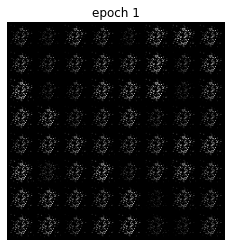

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1 of 100
Generator loss: 4.98519754, Discriminator loss: 0.71793795


469it [01:08,  6.88it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2 of 100
Generator loss: 5.80024099, Discriminator loss: 0.31748763


469it [01:08,  6.80it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3 of 100
Generator loss: 6.96402884, Discriminator loss: 0.11791687


469it [01:08,  6.87it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4 of 100
Generator loss: 7.53314161, Discriminator loss: 0.12826648


469it [01:07,  6.96it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5 of 100
Generator loss: 7.67761946, Discriminator loss: 0.14066283


469it [01:07,  6.94it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6 of 100
Generator loss: 6.73600197, Discriminator loss: 0.21972473


469it [01:08,  6.82it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7 of 100
Generator loss: 4.94535494, Discriminator loss: 0.36471426


469it [01:07,  6.94it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8 of 100
Generator loss: 4.23533916, Discriminator loss: 0.41092879


469it [01:07,  6.90it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9 of 100
Generator loss: 3.82470131, Discriminator loss: 0.49857607


469it [01:07,  6.93it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


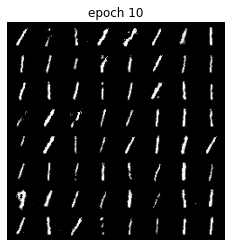

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10 of 100
Generator loss: 3.45276761, Discriminator loss: 0.54567891


469it [01:09,  6.74it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 11 of 100
Generator loss: 3.38747978, Discriminator loss: 0.55109626


469it [01:08,  6.89it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12 of 100
Generator loss: 3.12389398, Discriminator loss: 0.60785210


469it [01:08,  6.88it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13 of 100
Generator loss: 3.09013844, Discriminator loss: 0.61794055


469it [01:08,  6.85it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14 of 100
Generator loss: 3.03786206, Discriminator loss: 0.63307953


469it [01:09,  6.72it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15 of 100
Generator loss: 2.85793543, Discriminator loss: 0.66556233


469it [01:08,  6.85it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16 of 100
Generator loss: 2.79986691, Discriminator loss: 0.68540180


469it [01:10,  6.67it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17 of 100
Generator loss: 2.69314647, Discriminator loss: 0.75992447


469it [01:09,  6.73it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18 of 100
Generator loss: 2.67705584, Discriminator loss: 0.76867551


469it [01:08,  6.85it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19 of 100
Generator loss: 2.79107833, Discriminator loss: 0.75431120


469it [01:09,  6.73it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


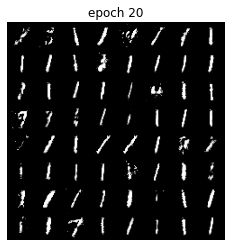

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 20 of 100
Generator loss: 2.82615614, Discriminator loss: 0.75835609


469it [01:09,  6.76it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 21 of 100
Generator loss: 2.77688122, Discriminator loss: 0.77864057


469it [01:10,  6.63it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 22 of 100
Generator loss: 2.70451307, Discriminator loss: 0.80366522


469it [01:10,  6.65it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 23 of 100
Generator loss: 2.64095283, Discriminator loss: 0.82985520


469it [01:11,  6.59it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 24 of 100
Generator loss: 2.59070635, Discriminator loss: 0.88086510


469it [01:10,  6.67it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 25 of 100
Generator loss: 2.54892564, Discriminator loss: 0.90793699


469it [01:10,  6.68it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 26 of 100
Generator loss: 2.52922487, Discriminator loss: 0.94399488


469it [01:10,  6.65it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 27 of 100
Generator loss: 2.49168134, Discriminator loss: 0.97963572


469it [01:10,  6.65it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 28 of 100
Generator loss: 2.39294219, Discriminator loss: 1.04449844


469it [01:11,  6.55it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 29 of 100
Generator loss: 2.35491180, Discriminator loss: 1.08208299


469it [01:11,  6.57it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


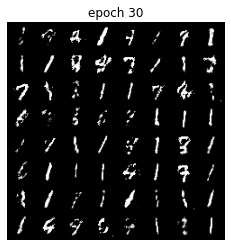

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 30 of 100
Generator loss: 2.28903270, Discriminator loss: 1.13542461


469it [01:10,  6.63it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 31 of 100
Generator loss: 2.28876042, Discriminator loss: 1.14809215


469it [01:10,  6.70it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 32 of 100
Generator loss: 2.21042514, Discriminator loss: 1.20523620


469it [01:11,  6.58it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 33 of 100
Generator loss: 2.17299366, Discriminator loss: 1.23985767


469it [01:11,  6.55it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 34 of 100
Generator loss: 2.07239938, Discriminator loss: 1.31383944


469it [01:13,  6.41it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 35 of 100
Generator loss: 2.08730173, Discriminator loss: 1.33225000


469it [01:13,  6.40it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 36 of 100
Generator loss: 1.98781633, Discriminator loss: 1.37245119


469it [01:13,  6.40it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 37 of 100
Generator loss: 1.96268952, Discriminator loss: 1.40444636


469it [01:11,  6.53it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 38 of 100
Generator loss: 1.97380602, Discriminator loss: 1.43036389


469it [01:11,  6.55it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 39 of 100
Generator loss: 1.94163406, Discriminator loss: 1.46179509


469it [01:13,  6.38it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


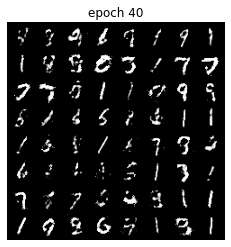

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 40 of 100
Generator loss: 1.88010716, Discriminator loss: 1.50734866


469it [01:13,  6.39it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 41 of 100
Generator loss: 1.78213358, Discriminator loss: 1.58212984


469it [01:11,  6.52it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 42 of 100
Generator loss: 1.81175947, Discriminator loss: 1.58359396


469it [01:11,  6.59it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 43 of 100
Generator loss: 1.76143825, Discriminator loss: 1.61065388


469it [01:14,  6.31it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 44 of 100
Generator loss: 1.76831090, Discriminator loss: 1.62702537


469it [01:12,  6.45it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 45 of 100
Generator loss: 1.75296891, Discriminator loss: 1.64211309


469it [01:13,  6.41it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 46 of 100
Generator loss: 1.72561276, Discriminator loss: 1.65516829


469it [01:13,  6.42it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 47 of 100
Generator loss: 1.71529841, Discriminator loss: 1.67650437


469it [01:12,  6.46it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 48 of 100
Generator loss: 1.68668914, Discriminator loss: 1.70865178


469it [01:14,  6.26it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 49 of 100
Generator loss: 1.61302638, Discriminator loss: 1.74189603


469it [01:15,  6.24it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


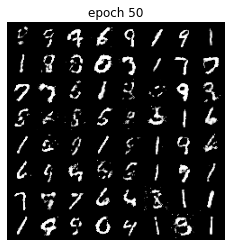

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 50 of 100
Generator loss: 1.64530098, Discriminator loss: 1.74755836


469it [01:13,  6.35it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 51 of 100
Generator loss: 1.64570379, Discriminator loss: 1.75091171


469it [01:14,  6.31it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 52 of 100
Generator loss: 1.61014152, Discriminator loss: 1.77745628


469it [01:16,  6.17it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 53 of 100
Generator loss: 1.60802293, Discriminator loss: 1.79438376


469it [01:15,  6.23it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 54 of 100
Generator loss: 1.61357617, Discriminator loss: 1.79640174


469it [01:15,  6.23it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 55 of 100
Generator loss: 1.57793748, Discriminator loss: 1.82598603


469it [01:15,  6.21it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 56 of 100
Generator loss: 1.58907008, Discriminator loss: 1.83393681


469it [01:15,  6.20it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 57 of 100
Generator loss: 1.53932381, Discriminator loss: 1.84714019


469it [01:13,  6.37it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 58 of 100
Generator loss: 1.50057161, Discriminator loss: 1.88966823


469it [01:16,  6.17it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 59 of 100
Generator loss: 1.55268610, Discriminator loss: 1.85965538


469it [01:14,  6.31it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


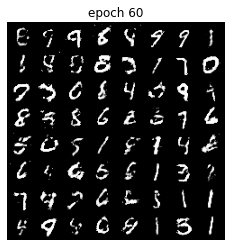

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 60 of 100
Generator loss: 1.52709234, Discriminator loss: 1.87336159


469it [01:16,  6.12it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 61 of 100
Generator loss: 1.53487098, Discriminator loss: 1.88077903


469it [01:17,  6.04it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 62 of 100
Generator loss: 1.50665569, Discriminator loss: 1.90352643


469it [01:17,  6.08it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 63 of 100
Generator loss: 1.50666499, Discriminator loss: 1.90667713


469it [01:17,  6.05it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 64 of 100
Generator loss: 1.49331951, Discriminator loss: 1.91359937


469it [01:14,  6.34it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 65 of 100
Generator loss: 1.45173478, Discriminator loss: 1.94872773


469it [01:14,  6.28it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 66 of 100
Generator loss: 1.46760893, Discriminator loss: 1.95231247


469it [01:17,  6.05it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 67 of 100
Generator loss: 1.43186808, Discriminator loss: 1.96552014


469it [01:15,  6.18it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 68 of 100
Generator loss: 1.44089973, Discriminator loss: 1.97014213


469it [01:15,  6.21it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 69 of 100
Generator loss: 1.43658304, Discriminator loss: 1.96894872


469it [01:18,  5.98it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


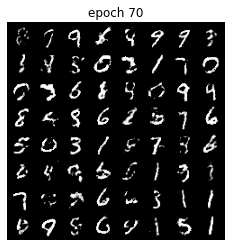

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 70 of 100
Generator loss: 1.43373883, Discriminator loss: 1.97521317


469it [01:18,  5.98it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 71 of 100
Generator loss: 1.45990872, Discriminator loss: 1.97303319


469it [01:17,  6.03it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 72 of 100
Generator loss: 1.38490248, Discriminator loss: 2.00622916


469it [01:15,  6.22it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 73 of 100
Generator loss: 1.40174711, Discriminator loss: 2.01455855


469it [01:18,  5.97it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 74 of 100
Generator loss: 1.37225449, Discriminator loss: 2.02699590


469it [01:18,  5.95it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 75 of 100
Generator loss: 1.41742241, Discriminator loss: 2.00439429


469it [01:17,  6.09it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 76 of 100
Generator loss: 1.42252231, Discriminator loss: 2.00522280


469it [01:19,  5.93it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 77 of 100
Generator loss: 1.36799204, Discriminator loss: 2.03665805


469it [01:19,  5.90it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 78 of 100
Generator loss: 1.37906826, Discriminator loss: 2.03137374


469it [01:20,  5.84it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 79 of 100
Generator loss: 1.39821672, Discriminator loss: 2.01952362


469it [01:19,  5.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


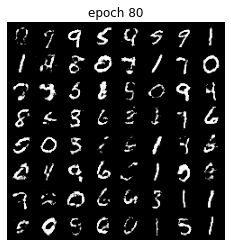

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 80 of 100
Generator loss: 1.38354611, Discriminator loss: 2.03797460


469it [01:16,  6.13it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 81 of 100
Generator loss: 1.35278237, Discriminator loss: 2.05912805


469it [01:17,  6.08it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 82 of 100
Generator loss: 1.36049497, Discriminator loss: 2.05473089


469it [01:16,  6.10it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 83 of 100
Generator loss: 1.36060047, Discriminator loss: 2.04931760


469it [01:20,  5.85it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 84 of 100
Generator loss: 1.34431219, Discriminator loss: 2.07014203


469it [01:18,  5.97it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 85 of 100
Generator loss: 1.34080541, Discriminator loss: 2.06633854


469it [01:21,  5.77it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 86 of 100
Generator loss: 1.30410707, Discriminator loss: 2.09587932


469it [01:19,  5.91it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 87 of 100
Generator loss: 1.32566953, Discriminator loss: 2.08808303


469it [01:21,  5.75it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 88 of 100
Generator loss: 1.37787998, Discriminator loss: 2.05325818


469it [01:19,  5.88it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 89 of 100
Generator loss: 1.31638491, Discriminator loss: 2.09214163


469it [01:21,  5.75it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


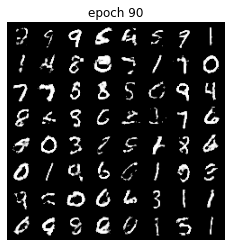

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 90 of 100
Generator loss: 1.34916735, Discriminator loss: 2.07308650


469it [01:19,  5.90it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 91 of 100
Generator loss: 1.33397937, Discriminator loss: 2.07285213


469it [01:21,  5.79it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 92 of 100
Generator loss: 1.34044814, Discriminator loss: 2.07767797


469it [01:22,  5.71it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 93 of 100
Generator loss: 1.30260098, Discriminator loss: 2.10061455


469it [01:23,  5.61it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 94 of 100
Generator loss: 1.32261217, Discriminator loss: 2.09427452


469it [01:21,  5.78it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 95 of 100
Generator loss: 1.35714388, Discriminator loss: 2.07104731


469it [01:23,  5.65it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 96 of 100
Generator loss: 1.29416895, Discriminator loss: 2.11471105


469it [01:24,  5.58it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 97 of 100
Generator loss: 1.31639779, Discriminator loss: 2.10395503


469it [01:24,  5.55it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 98 of 100
Generator loss: 1.29951739, Discriminator loss: 2.10760784


469it [01:25,  5.49it/s]                         
  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 99 of 100
Generator loss: 1.34669447, Discriminator loss: 2.08172655


469it [01:24,  5.54it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


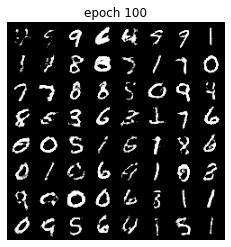

Epoch 100 of 100
Generator loss: 1.27068877, Discriminator loss: 2.12933803


In [11]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return criterion(output, true_label)

    
def discriminator_loss(output, true_label):
  return criterion(output, true_label)


def train_d(optim, real, fake):
  batch = real.size(0)
  real_lab = label_real(batch)
  fake_lab = label_fake(batch)

  optim.zero_grad()

  real_out = discriminator(real)
  real_loss = discriminator_loss(real_out, real_lab)
  real_loss.backward()

  fake_out = discriminator(fake)
  fake_loss = discriminator_loss(fake_out, fake_lab)
  fake_loss.backward()

  optim.step()

  return real_loss+fake_loss

def train_g(optim, fake, partb=False):
  batch = fake.size(0)
  real_lab = label_real(batch)

  optim.zero_grad()

  gen_out = discriminator(fake)
  if partb:
    gen_loss = generator_loss(1-gen_out, real_lab)
    (-gen_loss).backward()
  else:
    gen_loss = generator_loss(gen_out, real_lab)
    gen_loss.backward()

  optim.step()

  return gen_loss 

    
    

for epoch in range(epochs):
    partb = False
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        img = data[0]
        img = img.to(device)

        # interate over number of discriminator steps
        for step in range(k):
          fake = generator(create_noise(len(img), nz)).detach()
          loss_d += train_d(optim_d, img, fake)

        fake = generator(create_noise(len(img), nz))
        loss_g += train_g(optim_g, fake, partb)
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if epoch == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    if (epoch + 1) % 10 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [12]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [13]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

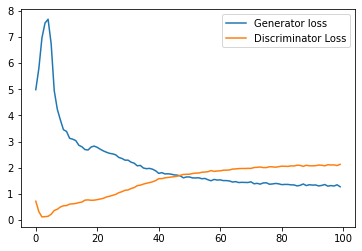

In [14]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')